<a href="https://colab.research.google.com/github/2303c50091/karuna/blob/main/resnet_152_for_eurosat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet152

In [ ]:
dataset = tfds.builder('eurosat')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpv3rd0t2utfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('

In [ ]:
info.features


FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [ ]:
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
list(info.splits.keys())

['train']

In [ ]:
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

In [ ]:
type(train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
datapoint = next(iter(train))
datapoint

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'Forest_687.jpg'>,
 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
 array([[[35, 59, 71],
         [35, 59, 71],
         [36, 60, 72],
         ...,
         [32, 60, 72],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[35, 59, 71],
         [34, 61, 72],
         [37, 61, 73],
         ...,
         [31, 59, 70],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[37, 64, 73],
         [35, 64, 72],
         [38, 65, 74],
         ...,
         [35, 63, 74],
         [31, 59, 70],
         [32, 61, 69]],
 
        ...,
 
        [[31, 54, 70],
         [29, 55, 68],
         [32, 59, 70],
         ...,
         [33, 62, 70],
         [32, 60, 71],
         [34, 62, 73]],
 
        [[33, 59, 72],
         [32, 59, 70],
         [32, 59, 70],
         ...,
         [32, 60, 71],
         [37, 66, 74],
         [35, 65, 73]],
 
        [[34, 62, 73],
         [33, 61, 72],
         [35, 62, 73],
     

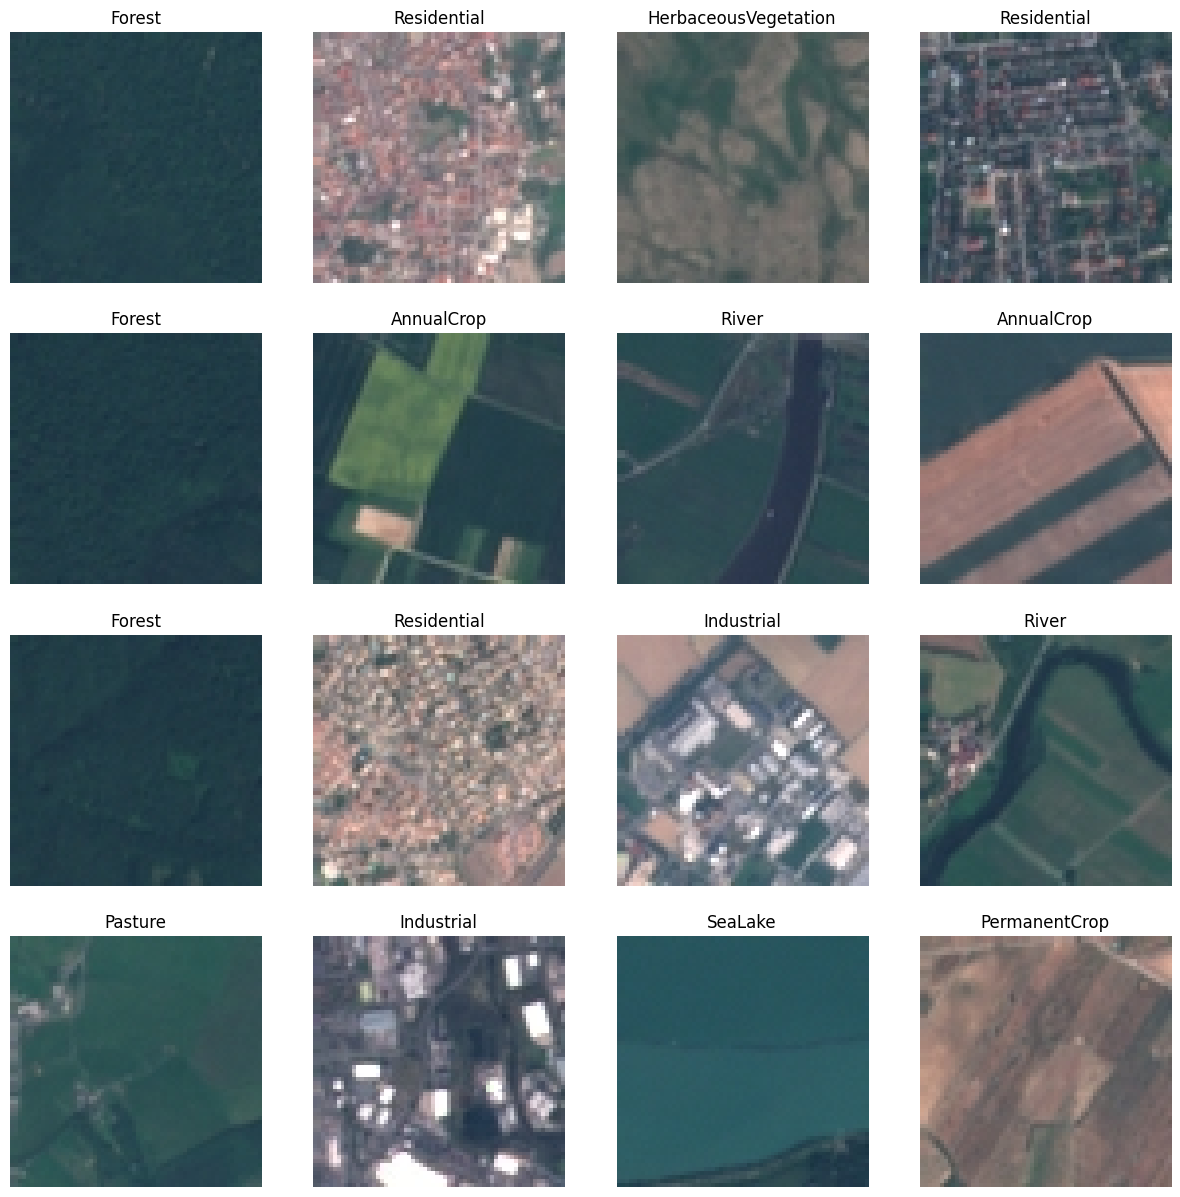

In [ ]:
#plot
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(16))):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [ ]:
NUM_EPOCHS = 1
BATCH_SIZE = 64
BUFFER_SIZE = 1000

IMAGE_SHAPE = [128, 125]
NUM_CLASSES = info.features["label"].num_classes

In [ ]:
#data augmentation
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.7411281>

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]


In [ ]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

In [ ]:
from tensorflow.keras.applications import ResNet152
import tensorflow as tf

# Load the ResNet152 model with pre-trained ImageNet weights
resnet = ResNet152(input_shape=IMAGE_SHAPE + [3], weights='imagenet', include_top=False)

# Freeze all layers in ResNet152
for layer in resnet.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
prediction = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Define the model
model = tf.keras.models.Model(inputs=resnet.input, outputs=prediction)


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='Lion',
    metrics=['accuracy']
)

In [ ]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

337/337 ━━━━━━━━━━━━━━━━━━━━ 4029s 12s/step - accuracy: 0.8609 - loss: 0.5067 - val_accuracy: 0.9282 - val_loss: 0.2307


In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.utils import plot_model

# Save the architecture diagram to a file
plot_model(
    model,
    to_file="model_architecture.png",  # Save as PNG file
    show_shapes=True,                  # Display the shape of each layer's output
    show_layer_names=True,             # Display layer names
    dpi=150                            # Set resolution for better clarity
)


In [ ]:
#evaluate

test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

43/43 ━━━━━━━━━━━━━━━━━━━━ 448s 10s/step - accuracy: 0.9371 - loss: 0.2478


[0.2443607598543167, 0.9359259009361267]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

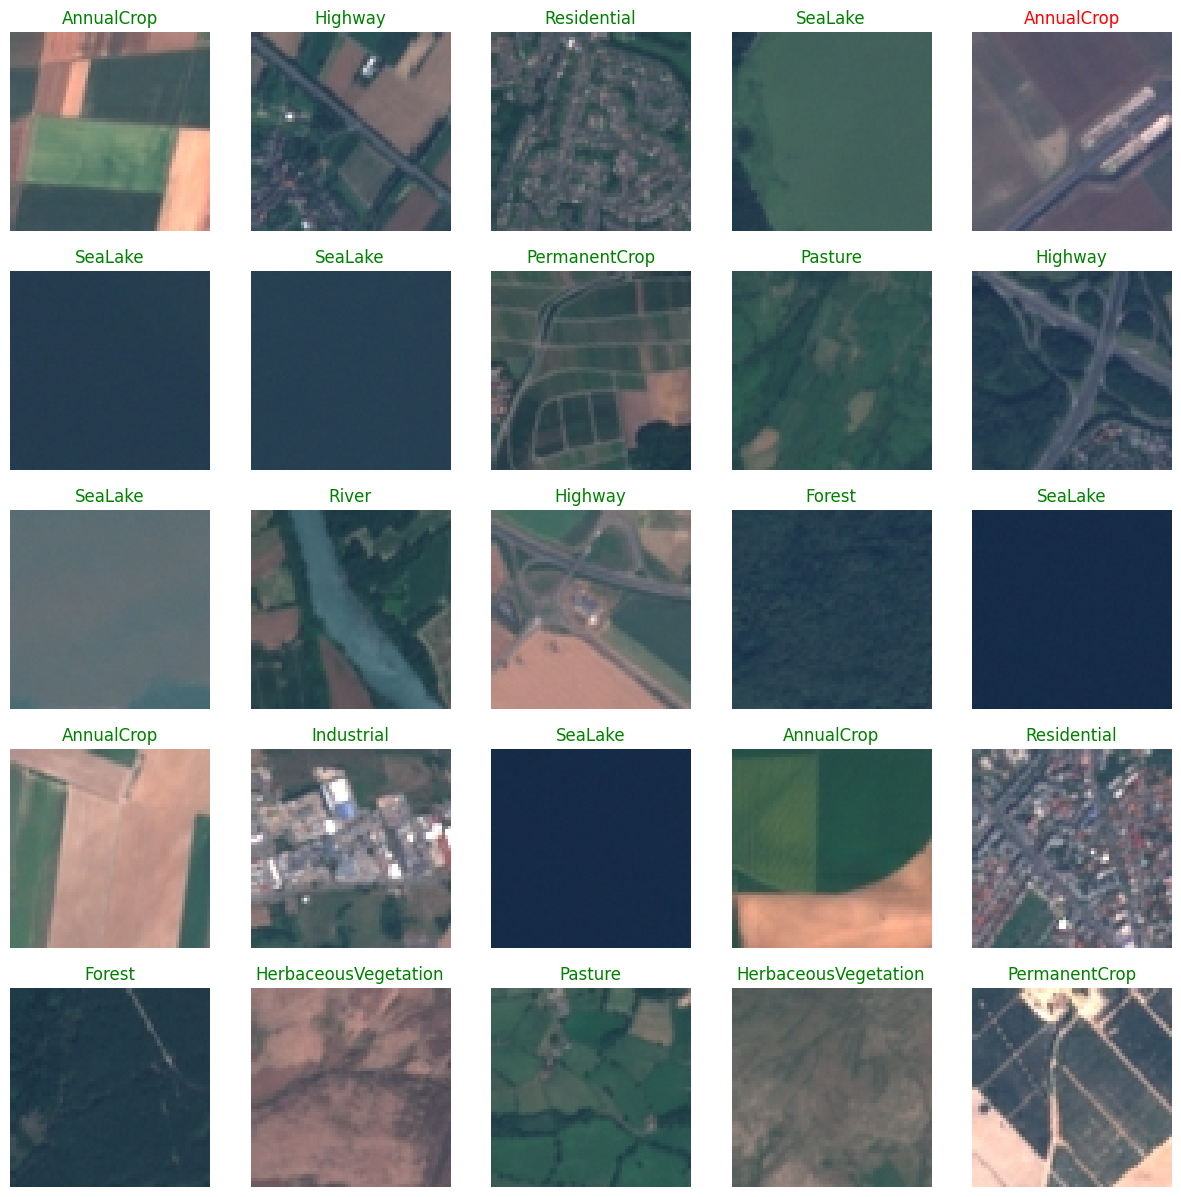

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 1000x1000 with 0 Axes>

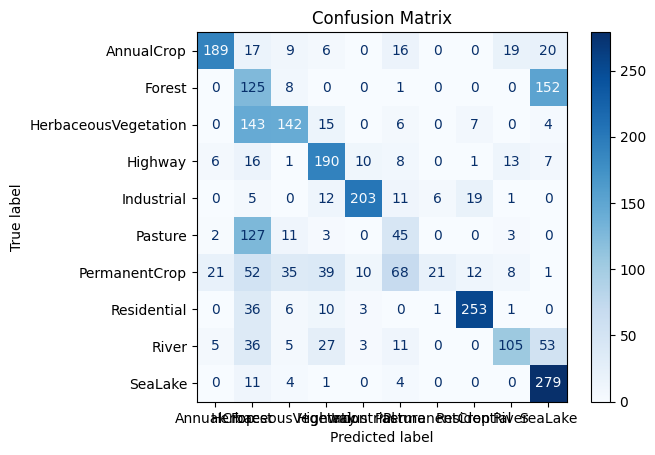

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Assuming you have the test dataset and the trained model
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get true and predicted labels
for images, labels in tfds.as_numpy(test_dataset): # Access batched images and labels as a tuple
    for i in range(len(images)): # Iterate through individual images in the batch
        image = images[i]
        label = labels[i]  # True label

        # Preprocess the image
        image = tf.image.resize(image, IMAGE_SHAPE)
        image = preprocess_input(image)  # Ensure preprocessing matches the model's input requirements
        image = np.expand_dims(image, axis=0)

        # Get the model's prediction
        prediction = np.argmax(model.predict(image), axis=1)[0]

        # Append to lists
        true_labels.append(label)
        predicted_labels.append(prediction)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

<Figure size 1000x1000 with 0 Axes>

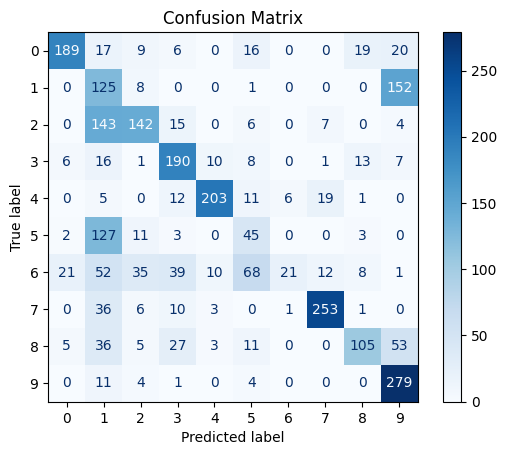

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create numeric labels for the classes
num_classes = len(np.unique(true_labels))  # Determine the number of classes
class_labels = [str(i) for i in range(num_classes)]  # Create labels: ['0', '1', ..., 'n-1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Example confusion matrix values from the image (replace these with your actual values)
confusion_matrix = np.array([
    [189, 17, 9, 6, 0, 16, 0, 19, 20, 0],
    [0, 125, 8, 0, 0, 0, 0, 0, 152, 0],
    [0, 143, 142, 15, 6, 0, 7, 4, 0, 0],
    [6, 16, 1, 190, 10, 8, 0, 1, 13, 7],
    [0, 5, 0, 12, 203, 11, 6, 19, 1, 0],
    [0, 127, 11, 3, 0, 45, 0, 0, 3, 0],
    [21, 52, 35, 39, 10, 68, 21, 12, 8, 1],
    [0, 36, 6, 10, 3, 0, 1, 253, 3, 0],
    [5, 36, 5, 27, 3, 11, 0, 105, 53, 0],
    [0, 11, 4, 1, 0, 4, 0, 0, 0, 279]
])

# Calculate metrics
true_labels = []
predicted_labels = []

# Generate true and predicted labels based on confusion matrix
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        true_labels += [i] * confusion_matrix[i, j]
        predicted_labels += [j] * confusion_matrix[i, j]

# Metrics calculation
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Normalized F1-score
normalized_f1 = f1 / np.sum(f1)

# Create a table
import pandas as pd

classes = [str(i) for i in range(len(precision))]
data = {
    "Class": classes,
    "Accuracy": [round(accuracy, 2)] * len(classes),
    "Precision": precision.round(2),
    "Recall": recall.round(2),
    "F1-Score": f1.round(2),
    "Normalized F1-Score": normalized_f1.round(2),
}

df = pd.DataFrame(data)

# Display the table
print(df)


  Class  Accuracy  Precision  Recall  F1-Score  Normalized F1-Score
0     0      0.56       0.86    0.68      0.76                 0.14
1     1      0.56       0.22    0.44      0.29                 0.05
2     2      0.56       0.64    0.45      0.53                 0.10
3     3      0.56       0.63    0.75      0.68                 0.13
4     4      0.56       0.86    0.79      0.83                 0.15
5     5      0.56       0.28    0.24      0.26                 0.05
6     6      0.56       0.60    0.08      0.14                 0.03
7     7      0.56       0.61    0.81      0.70                 0.13
8     8      0.56       0.21    0.22      0.21                 0.04
9     9      0.56       0.97    0.93      0.95                 0.18


In [ ]:
import pandas as pd

# Data for the table
data = {
    "Model": ["ResNet152", "ResNet50", "EfficientNet", "VGG16"],
    "Accuracy (%)": [94.0, 92.8, 91.1, 89.8]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the table as a CSV file
file_name = "model_accuracy_table.csv"
df.to_csv(file_name, index=False)
print(f"Table saved as {file_name}")


Table saved as model_accuracy_table.csv
